In [55]:
from astropy import time
from astropy import units as u

from poliastro import iod

from poliastro.bodies import Sun, Earth, Jupiter
from poliastro.ephem import Ephem
from poliastro.frames import Planes
from poliastro.plotting import StaticOrbitPlotter
from poliastro.twobody import Orbit
from poliastro.util import norm

[0.         7.81989358 0.        ] km / s


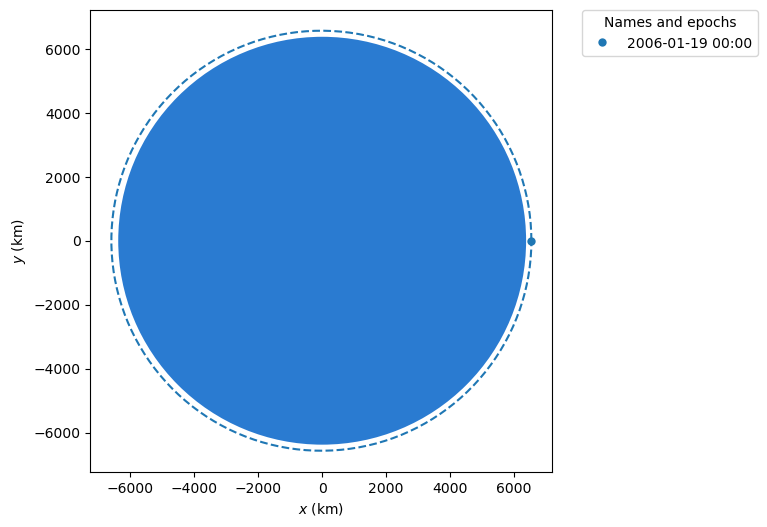

In [56]:
r_p = Earth.R + 165 * u.km
r_a = Earth.R + 215 * u.km

a_parking = (r_p + r_a) / 2
ecc_parking = 1 - r_p / a_parking

parking = Orbit.from_classical(
    Earth,
    a_parking,
    ecc_parking,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,  # We don't mind
    time.Time("2006-01-19", scale="utc"),
)

print(parking.v)
parking.plot()

Relative error of 3.20 %


(-20000.0, 20000.0)

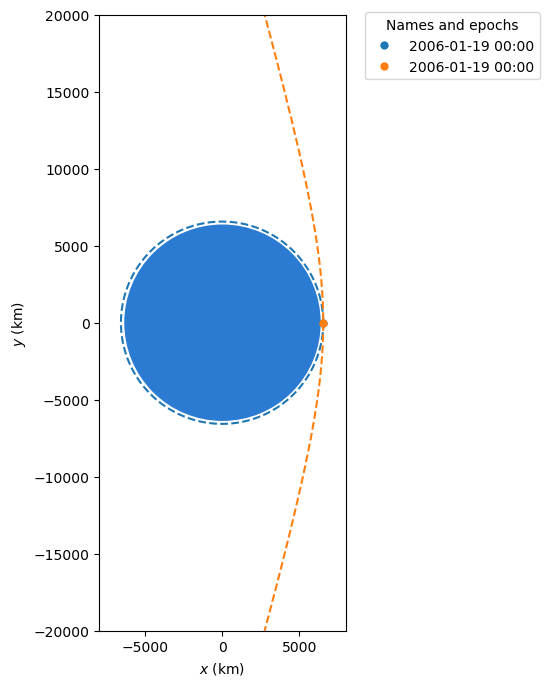

In [57]:
C_3_A = 157.6561 * u.km**2 / u.s**2  # Designed

a_exit = -(Earth.k / C_3_A).to(u.km)
ecc_exit = 1 - r_p / a_exit

exit = Orbit.from_classical(
    Earth,
    a_exit,
    ecc_exit,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,  # We don't mind
    time.Time("2006-01-19", scale="utc"),
)

norm(exit.v).to(u.km / u.s)
v_estimated = 16.2 * u.km / u.s

print(
    "Relative error of {:.2f} %".format(
        (norm(exit.v) - v_estimated) / v_estimated * 100
    )
)

from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
op = StaticOrbitPlotter(ax=ax)

op.plot(parking)
op.plot(exit)

ax.set_xlim(-8000, 8000)
ax.set_ylim(-20000, 20000)


In [58]:
from poliastro.maneuver import Maneuver
from poliastro.util import time_range


nh_date = time.Time("2006-01-19 19:00", scale="utc").tdb
nh_flyby_date = time.Time("2007-02-28 05:43:40", scale="utc").tdb
nh_tof = nh_flyby_date - nh_date

earth = Ephem.from_body(Earth, time_range(nh_date, end=nh_flyby_date))
jupiter = Ephem.from_body(Jupiter, time_range(nh_date, end=nh_flyby_date))


nh_r_0, v_earth = Ephem.from_body(Earth, nh_date).rv(nh_date)
nh_r_f, v_jup = Ephem.from_body(Jupiter, nh_flyby_date).rv(nh_flyby_date)

# Solve for the transfer maneuver
ss_earth = Orbit.from_ephem(Sun, earth, nh_date)
ss_jupiter = Orbit.from_ephem(Sun, jupiter, nh_flyby_date)

man_lambert = Maneuver.lambert(ss_earth, ss_jupiter)
#propogate orbit out to Jupiter
ic_1,ic_2=ss_earth.apply_maneuver(man_lambert,intermediate=True)
#ic_1 = ic_1.propagate(nh_flyby_date-nh_date)



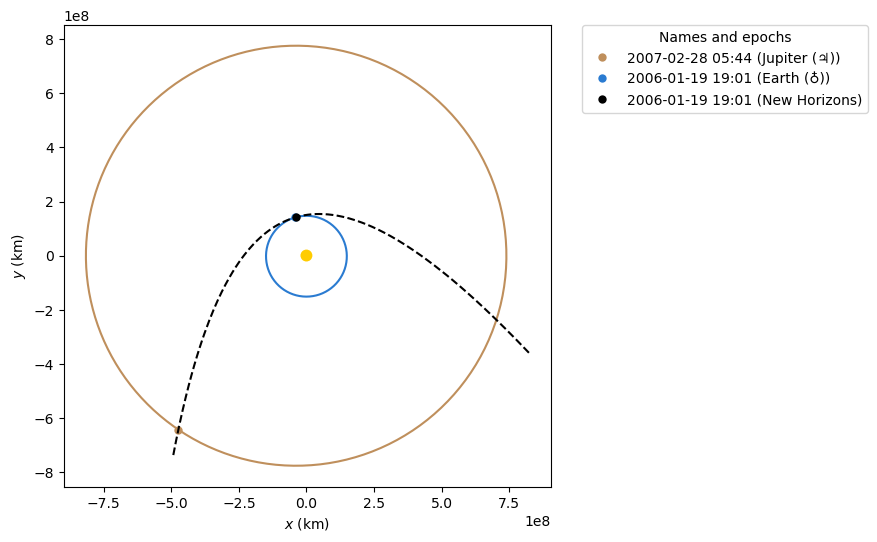

In [59]:

op = StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)

op.plot_body_orbit(Jupiter, nh_flyby_date)
op.plot_body_orbit(Earth, nh_date)

op.plot(ic_1, label="New Horizons", color="k")

403.44699075114016
[-21838.71074438 758108.91362607 322002.05903625] km
353167 x -7593689 km x 23.0 deg (JupiterICRS) orbit around Jupiter (♃) at epoch 2007-02-28 05:44:45.185 (TDB)


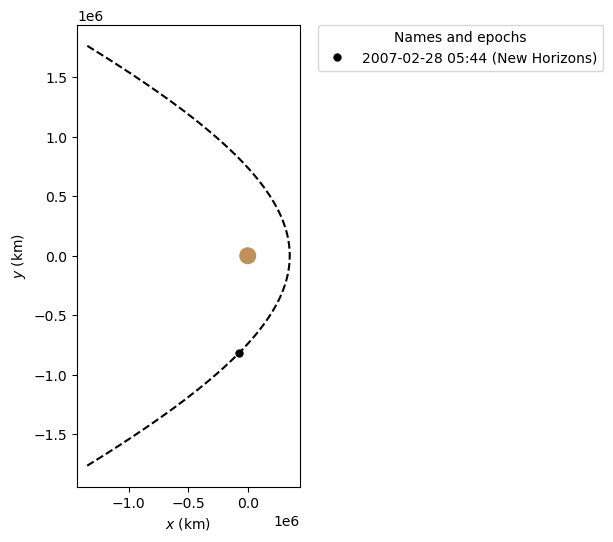

In [61]:
#arrival at jupiter
print((nh_flyby_date-nh_date)-1*u.day)
ic_f = ic_1.propagate((nh_flyby_date-nh_date)-0.5*u.day)


r_jupiter,v_jupiter = ss_jupiter.r,ss_jupiter.v
r_sc_arriv = ic_f.r-r_jupiter
v_sc_arriv = ic_f.v-v_jupiter
print(r_sc_arriv)

arrival_orbit = Orbit.from_vectors(Jupiter,r_sc_arriv,v_sc_arriv,epoch=nh_flyby_date)
print(arrival_orbit)
op_jup = StaticOrbitPlotter()

op_jup.plot(arrival_orbit, label="New Horizons", color="k")